In [3]:
import os
os.chdir('..')

from src.models import patient_evolution

In [26]:
import numpy as np
import networkx as nx
import pandas as pd
import collections
from tqdm import tqdm

# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman',
               pop_size = 1000, seed = None):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 5, 0.4, seed)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size, seed=seed)
    elif graph_model == 'SP':
        G = nx.read_gpickle('src/models/Grafo_Zonas_SP.gpickle')
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000, seed=None):
    G = init_graph(initial_infection, graph_model, pop_size, seed)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """   
    for node in G.nodes():
        G.nodes[node].update({
                      'status': 'susceptible', 
                      'infection_day' : -1, 
                      'contacts_infected' : 0
        })

    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size, replace = False)
    
    for i in infected:
        patient_evolution.susceptible_to_exposed(G.nodes[i], 0)

def lambda_leak_value(infected_ratio, max_value=0.05, exp=3): 
    return (infected_ratio**exp)*max_value

def spread_one_step(G, day, infected_ratio, p_r = 0.5, lambda_leak_max = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
    
    lambda_leak = lambda_leak_value(infected_ratio, max_value = lambda_leak_max)
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    newly_infected = np.unique(newly_infected)
    
    patient_evolution.infect_graph(G, newly_infected, day)
    
    return newly_infected.size

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and removed
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def current_status_by_zone(G):   
    result = collections.Counter(node['home'] for i,node in G.nodes(data=True) \
                                            if node['status']=='infected')

    people_per_zone = dict(collections.Counter(node['home'] for i,node in G.nodes(data=True)))
    
    for k,v in result.items():
        result[k] = v/people_per_zone[k]
        
    return dict(result)


def get_mean_contacts_infected(G):
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True)\
                                                             if node['status'] == 'removed']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
            
        return contacts_infected
    
def get_time_series_row(G, pop):
    status = current_status(G)
    s = status['susceptible'] / pop
    i = status['infected'] / pop
    r = status['removed'] / pop
    h = status['hospitalized'] / pop
    e = status['exposed'] / pop

    contacts_infected = get_mean_contacts_infected(G)
    
    return s, e, i, r, h, contacts_infected, status
    
def simulate_pandemic(work_r=0, school_r = 0, home_r=0, initial_infection=.05, recover_time=12, p_r=.5, lambda_leak=.05,
                      graph_model = 'relaxed_caveman', pop_size = 1000,
                      seed = None, it=None):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)
    
    data_per_region = []
    
    zones = range(1, 343)
    
    for day in tqdm(range(250)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
    
        patient_evolution.update_graph(G)
        
        #This was not being used, was this expected?
        #newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected, status])
        
        
        if graph_model == 'SP':
            data_per_region.append(current_status_by_zone(G))
            spread_thorugh_regions(G=G, day=day, zones=zones, school_r=school_r, work_r=work_r, 
                                               p_r = p_r, lambda_leak_max=lambda_leak, home_r=home_r)
        
        else:
             _ = spread_one_step(G, day, status['infected'] / pop, p_r, lambda_leak)
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G, data_per_region


In [27]:
def subgraph_of_zone(G, zone, relation):
    zone_nodes = [x for x,y in G.nodes(data=True) if y[relation]==zone]
    return G.subgraph(zone_nodes)

def percentage_infected(G):
    pop = len(G.nodes)
    if pop < 1: return 0
    
    infected = len([True for i,node in G.nodes(data=True) if node['status']=='infected'])
    
    return infected/pop

def leak_and_spread(G, day, p_r = 0.5, lambda_leak_max = 0.05, zone_restriction=0):
    
    newly_infected = 0
    
    infected_ratio = percentage_infected(G)
    
    if infected_ratio <= 0: return 0
    
    lambda_leak = lambda_leak_value(infected_ratio, max_value = lambda_leak_max)
    
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                patient_evolution.infect_node(G.nodes[node], day)
                newly_infected += 1
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected':
                        if np.random.random() < p_r and np.random.random() > zone_restriction:
                            patient_evolution.infect_node(G.nodes[node], day)
                            G.nodes[contact]['contacts_infected'] += 1
                            newly_infected += 1
                            break  
                            
    return newly_infected


def spread_thorugh_regions(G, day, zones, school_r, work_r, 
                                               p_r = 0.5, lambda_leak_max = 0.05,home_r=0, ):
    
    newly_infected = {
        'home' : 0,
        'work' : 0,
        'school' : 0, 
    }
    
    for restriction, relation in zip([home_r, work_r, school_r], ['home','work', 'school']):
        for z in zones:
            sub_Graph = subgraph_of_zone(G, z, relation)
            newly_infected[relation] += leak_and_spread(sub_Graph, day, p_r, lambda_leak_max, restriction)
    
    return newly_infected

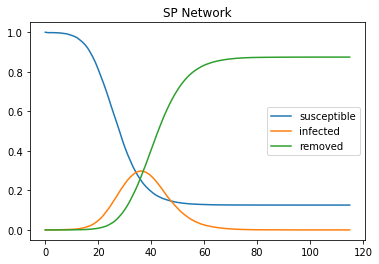

In [34]:
import matplotlib.pyplot as plt

time_series, G, data_per_region = simulate_pandemic(graph_model = 'SP', p_r = 0.3,
                                                    lambda_leak=0, pop_size=5000, 
                                                    initial_infection = 100/50000)



plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.legend()
plt.title('SP Network')
plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

In [31]:
time_series_wr, G_wr, data_per_region_wr = simulate_pandemic(work_r=.5, school_r=1, graph_model = 'SP', p_r = 0.3,
                                                    lambda_leak=0, pop_size=5000, 
                                                    initial_infection = 100/50000)



 58%|██████████████████████████████████████████████                                  | 144/250 [15:08<11:08,  6.31s/it]


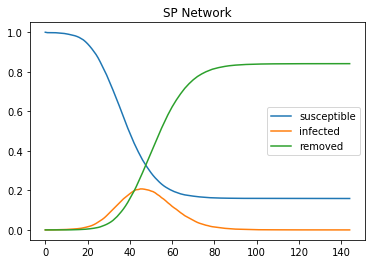

In [32]:
import matplotlib.pyplot as plt

plt.plot(time_series_wr.index, time_series_wr['susceptible'], label = 'susceptible')
plt.plot(time_series_wr.index, time_series_wr['infected'], label = 'infected')
plt.plot(time_series_wr.index, time_series_wr['removed'], label = 'removed')
plt.legend()
plt.title('SP Network')
plt.savefig('SP network Simulation - 50% job reducv2.png', fromat='png', dpi = 300)
plt.show()

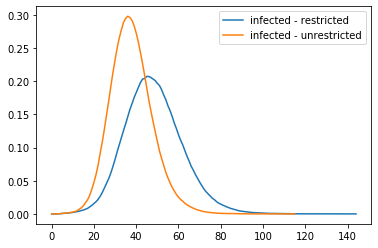

In [37]:
plt.plot(time_series_wr.index, time_series_wr['infected'], label = 'infected - restricted')
plt.plot(time_series.index, time_series['infected'], label = 'infected - unrestricted')
plt.legend()
plt.savefig('infection curves comparison.png', fromat='png', dpi = 300)
